# Project: Naïve-Bayes from scratch

## Task 1: Import the Libraries

In [10]:
from pprint import pprint
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

## Task 2: Load the Dataset

In [11]:
df = pd.read_csv('/usercode/adult.csv').drop(columns=['fnlwgt', 'capital-gain', 'capital-loss'])
df.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,30,United-States,<=50K


## Task 3: Pre-process the Data

In [12]:
# Use the following code to check for nulls:
df.isnull().sum()

age                0
workclass          0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [13]:
# Use the following code to check for missing values present as a custom set of characters:
categorical = list(set(df.columns)-set(df._get_numeric_data().columns))
uniques = {}
for col in categorical:
    uniques[col] = df[col].unique().tolist()
pprint(uniques)

{'education': ['11th',
               'HS-grad',
               'Assoc-acdm',
               'Some-college',
               '10th',
               'Prof-school',
               '7th-8th',
               'Bachelors',
               'Masters',
               'Doctorate',
               '5th-6th',
               'Assoc-voc',
               '9th',
               '12th',
               '1st-4th',
               'Preschool'],
 'gender': ['Male', 'Female'],
 'income': ['<=50K', '>50K'],
 'marital-status': ['Never-married',
                    'Married-civ-spouse',
                    'Widowed',
                    'Divorced',
                    'Separated',
                    'Married-spouse-absent',
                    'Married-AF-spouse'],
 'native-country': ['United-States',
                    '?',
                    'Peru',
                    'Guatemala',
                    'Mexico',
                    'Dominican-Republic',
                    'Ireland',
                    'German

In [14]:
# Use the following code to remove the rows with missing values from the DataFrame:
miss = dict(zip(categorical, [0]*len(categorical)))
for c in miss:
    miss[c] = len(df[df[c]=='?'])
pprint(miss)
len(df)

{'education': 0,
 'gender': 0,
 'income': 0,
 'marital-status': 0,
 'native-country': 857,
 'occupation': 2809,
 'race': 0,
 'relationship': 0,
 'workclass': 2799}


48842

In [15]:
# Use the following code to remove the rows with missing values from the DataFrame:
for c in miss:
    df.drop(df[df[c] == '?'].index, inplace=True)
len(df)

45222

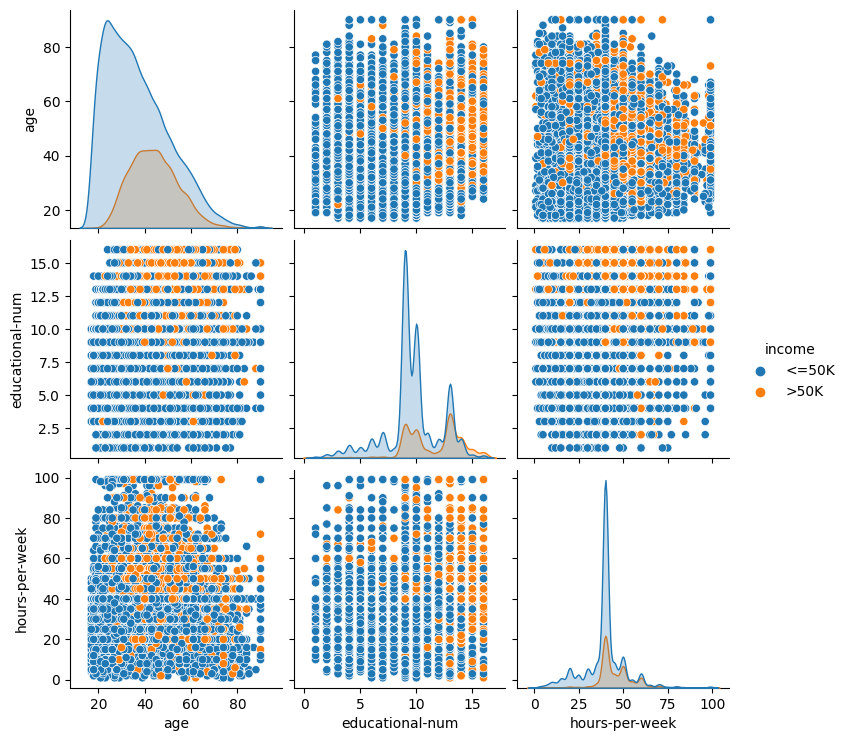

In [16]:
# Use the following code to create the pair-plot:
sns.pairplot(df, hue = 'income')

## Task 4, 5, 6, 7, 8, and 9: Implement the Naïve-Bayes Classifier

In [17]:
class NaiveBayes():
    # Task 4: The Initialization Method
    # __init__(): The initialization method, where all the class variables will be initialized.
    def __init__(self, data, target, cont_cols=[]):
        self.target = target
        self.data = data
        self.cont_cols = cont_cols if len(cont_cols)>0 else self.data._get_numeric_data().columns
        self.maximum = {}
        self.minimum = {}

    # Task 5: Outlier Handler
    # outlier_handler(): Outliers in all numerical columns need to be handled before they are transformed into discrete classes.
    def outlier_handler(self, q1, q3, column):
        results = []
        iqr = q3-q1
        self.maximum[column] = q3+1.5*iqr
        self.minimum[column] = q1-1.5*iqr
        for x in self.data[column]: 
            if x > self.maximum[column]:
                results.append(self.maximum[column])
            elif x < self.minimum[column]:
                results.append(self.minimum[column])
            else:
                results.append(x)
        return results
    
    # Task 6: Convert Numeric Features to Categorical
    # numeric2categoric(): All numerical columns must be converted to categorical class features before training the model. 
    # This function will call the outlier_handler() method to handle outliers.
    def numeric2categoric(self):
        for col in self.cont_cols:
            q1, q3 = np.percentile(self.data[col], [25, 75])
            # Handle outliers
            self.data[col] = self.outlier_handler(q1, q3, col)
            # Binning
            bins = np.linspace(self.minimum[col], self.maximum[col], 10)
            self.data[col] = np.digitize(self.data[col], bins)
            self.data[col] = self.data[col].apply(str)
    
    # Task 7: Prepare Data
    # prepare_dataset(): This function will use the numeric2categoric() method to convert all numerical columns to categorical when called. 
    # It will also split the loaded dataset into training and testing sets for training and evaluation.
    def prepare_data(self):    
        if len(self.cont_cols) > 0:
            self.numeric2categoric()
        self.df_train, self.df_test = train_test_split(self.data, test_size=0.2, random_state=42)

    # Task 8: The Train Function
    # train(): This method will compute and save the probabilities required for the Naive-Bayes model inference.
    def train(self):
        self.probs = {}
        self.target_probabilities = {}
        for target_class in list(set(self.df_train[self.target])):
            self.probs[target_class] = {}
            for feature_name in list(self.df_train.columns):
                if feature_name != self.target:
                    unique_classes = list(set(self.data[feature_name]))
                    self.probs[target_class][feature_name] = dict(zip(unique_classes, np.zeros(len(unique_classes))))
                    for feature_class in unique_classes:
                        # Counts of feature class intersect target class
                        count_feature_intersect_target = len(self.df_train.loc[(self.df_train[feature_name]==str(feature_class)) & (self.df_train[self.target] == target_class)])
                        # Counts of target class 
                        count_target = len(self.df_train.loc[(self.df_train[self.target] == target_class)])
                        # Probability of feature given target
                        self.probs[target_class][feature_name][str(feature_class)] = (count_feature_intersect_target+1)/(count_target+1)  
            # Initialize each class in results with the probability of the class P(T)
            self.target_probabilities[target_class] = len(self.df_train[self.df_train[self.target]==target_class])/len(self.df_train)
                 

    # Task 9: The Predict Function
    # predict(): This method will generate predictions given the required input features.
    def predict(self, row):
        X = dict(zip(self.df_test.columns, row))
    
        class_probabilities = self.target_probabilities.copy()

        target_classes = self.df_test[self.target].unique()
        for target_class in target_classes:
            # multiply each probability with P(X|T) for each feature class X in the dataset
            for feature_name in list(X.keys()):
                if feature_name != self.target:
                    class_probabilities[target_class] *= self.probs[target_class][feature_name][str(X[feature_name])]
                    
        max_class = self.df_train[self.target][0]
           
        for target_class in class_probabilities.keys():
            if (class_probabilities[target_class] > class_probabilities[max_class]):
                max_class = target_class
        return max_class
    

## Task 10: Model Creation, Training, and Prediction

In [18]:
clf = NaiveBayes(df.copy(), 'income', ['age', 'educational-num', 'hours-per-week'])
clf.prepare_data()

In [19]:
clf.train()
pprint(clf.probs)

{'<=50K': {'age': {'10': 0.00614580649909837,
                   '3': 0.21098148897802965,
                   '4': 0.26478489677253153,
                   '5': 0.1952305597468075,
                   '6': 0.15795090715048027,
                   '7': 0.09152467522908769,
                   '8': 0.05718912155448423,
                   '9': 0.016450152725131565},
           'education': {'10th': 0.03352592647112943,
                         '11th': 0.04522871968498141,
                         '12th': 0.015456519339049792,
                         '1st-4th': 0.005667390424318257,
                         '5th-6th': 0.012107606815589004,
                         '7th-8th': 0.021859934493798992,
                         '9th': 0.018511021970338205,
                         'Assoc-acdm': 0.032348286902439925,
                         'Assoc-voc': 0.042947043020645496,
                         'Bachelors': 0.12942994884628123,
                         'Doctorate': 0.004342545909542561,
       

In [20]:
predictions = [clf.predict(row) for _, row in clf.df_test.iterrows()]

## Task 11: The Confusion Matrix

[Text(0, 0.5, '>50k'), Text(0, 1.5, '<=50k')]

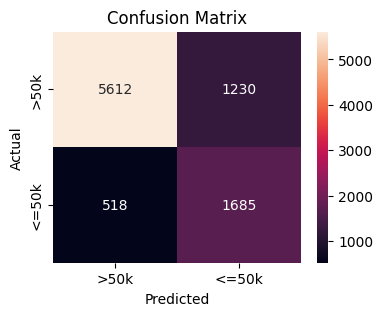

In [21]:
actuals = clf.df_test['income']
cm = confusion_matrix(actuals, predictions)
plt.figure(figsize=(4,3))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['>50k', '<=50k']); ax.yaxis.set_ticklabels(['>50k', '<=50k'])

## Task 12: Model Evaluation

In [22]:
print(classification_report(actuals, predictions))

              precision    recall  f1-score   support

       <=50K       0.92      0.82      0.87      6842
        >50K       0.58      0.76      0.66      2203

    accuracy                           0.81      9045
   macro avg       0.75      0.79      0.76      9045
weighted avg       0.83      0.81      0.81      9045



# End